## **Classical TDA (Persistent Homology)**

In [1]:
# Fundamental Libraries
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Libraries for Statistical Analysis
from scipy import stats                                 # Statistical Functions module from Scipy
import statsmodels.api as sm                            # Autocorrelation Value
from statsmodels.graphics.tsaplots import plot_acf      # Autocorrelation Function Plot
from statsmodels.graphics.tsaplots import plot_pacf     # Partial Autocorrelation Function Plot
from pandas.plotting import lag_plot                    # Lag Plot
from statsmodels.tsa.seasonal import seasonal_decompose # Time Series Decomposition
from statsmodels.tsa.stattools import adfuller          # Augmented Dickey Fuller Test (for stationarity / unit root)

In [3]:
# Libraries for Topological Data Analysis
!pip install -U giotto-tda --q                          # Complete TDA library from Giotto
from gtda.time_series import SingleTakensEmbedding      # Create Takens Embedding of Time Series
from gtda.plotting import plot_point_cloud              # Plot pointcloud from Takens Embedding in phase space
from gtda.diagrams import PersistenceLandscape          # Create persistence landscape from Takens Embedding
from gtda.diagrams import BettiCurve                    # Create Betti Curves
from gtda.diagrams import PersistenceImage              # Create persistence image
from gtda.homology import VietorisRipsPersistence       # Create persistence diagrams of the VietorisRips filtration
from gtda.homology import EuclideanCechPersistence      # Create persistence diagrams of the Čech filtration
from gtda.homology import WeightedRipsPersistence       # Create persistence diagrams of the Weighted (Vietoris–)Rips filtrations
from gtda.homology import WeakAlphaPersistence          # Create persistence diagrams of the Weak Alpha filtration
from gtda.homology import SparseRipsPersistence         # Create persistence diagrams of the SparseRips filtration

#### <font color="blue">**Technical Documentation**

* ***Takens' Embedding***

  * *Create a point cloud out of a finite dataset using a specific metric (Transform time series into point cloud by [Taken's Embedding Theorem](https://en.wikipedia.org/wiki/Takens%27s_theorem))*

  * *Please notice the technical documentation of the TDA library from [Giotto TDA](https://giotto-ai.github.io/gtda-docs/latest/notebooks/topology_time_series.html)*
   
  * *We will use the hyperparameter as an upper bound, and let the tool search for optimal values within that max range (in next step: parameters_type="search")*
  
    * *embedding_time_delay = 3, because we saw in the autocorrelation analysis that the max lag is 2*
    * *An increased stride = reduces the time series density and allows for a more efficient computation of the TDA result.*
    * *embedding_dimension uses [false nearest neighbours method](https://en.m.wikipedia.org/wiki/False_nearest_neighbor_algorithm#:~:text=Within%20abstract%20algebra%2C%20the%20false,change%20with%20increasing%20embedding%20dimension.) to automatically determine ideal dimension.*

* ***Persistence diagrams (VietorisRipsPersistence)***
       
  * *encodes topological information on the dynamics in the embedding space.*

  * The horizontal axis corresponds to the moment in which a homological generator is born
  
  * the vertical axis corresponds to the moments in which an homological generator dies. 
  
  * In the plot below for a single window, the generators of each homology dimension $H_0$, $H_1$ and $H_2$ are coloured differently

    * $H_0$ = the number of connected components

    * $H_1$ = the number of (one-dimensional) holes / loops

    * $H_2$ =  the number of (two-dimensional) voids

   * We identify the most stabile invariant(s) by increasing the ε ball monitoring the birth and death of connected components (during filtration) in the persistent diagram
   
   * Given a point cloud in Euclidean space, an abstract metric space encoded by a distance matrix, or the adjacency matrix of a weighted undirected graph, information about the appearance and disappearance of topological features (technically, homology classes) of various dimensions and at different scales is summarised in the corresponding persistence diagram (view [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html#gtda.homology.VietorisRipsPersistence))

   * See [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/plotting/gtda.plotting.plot_diagram.html?highlight=diag#gtda.plotting.plot_diagram) from Giotto library of the computation of persistence diagrams and here about [VietorisRipsPersistence
](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/homology/gtda.homology.VietorisRipsPersistence.html)

* ***Create Persistence Landscape from Persistent Diagrams:***

  * *see the [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.PersistenceLandscape.html) of the Giotto library*

* ***Create Betti Curves among Persistent Diagrams:***

  * *compute the distances among diagrams using the lp norm of the Betti curves.*
  
  * *see [technical documentation](https://giotto-ai.github.io/gtda-docs/latest/modules/generated/diagrams/representations/gtda.diagrams.BettiCurve.html?highlight=betti#gtda.diagrams.BettiCurve).*

#### <font color="blue">**Papers**

* https://arxiv.org/abs/1701.06081: Topology data analysis of critical transitions in financial networks (Gidea, 2017)
* https://arxiv.org/abs/1703.04385: Topological Data Analysis of Financial Time Series: Landscapes of Crashes (Gidea & Katz, 2017)
* http://kth.diva-portal.org/smash/get/diva2:1169943/FULLTEXT01.pdf: An exploration of topological properties of high-frequency onedimensional financial time series data using TDA (Truong, 2017)
* https://arxiv.org/abs/1708.09359: Computational Topology Techniques for Characterizing Time-Series Data (Sanderson et al 2017)

#### <font color="blue">**Data Preparation**

<AxesSubplot:title={'center':'Time Series'}, xlabel='date'>

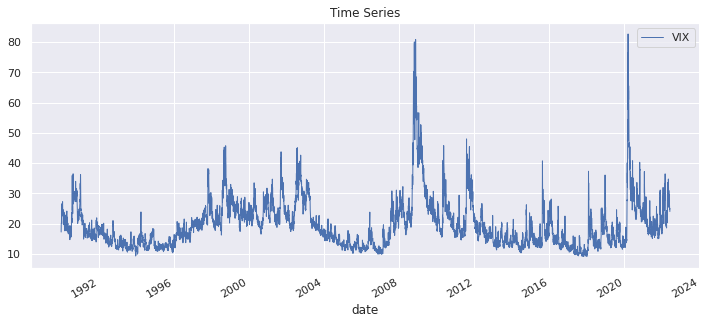

In [9]:
# Import S&P500 data
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/sp500.csv'
sp500_raw = pd.read_csv(url)

# Import VIX data (volatility)
url = 'https://raw.githubusercontent.com/deltorobarba/repo/master/vix.csv'
vix_raw = pd.read_csv(url)

# Select specific features, and rename features
sp500_raw = sp500_raw[['Date', 'Close']].rename(columns={"Date": "date", "Close": "sp500"})
vix_raw = vix_raw[['Date', 'Close']].rename(columns={"Date": "date", "Close": "VIX"})

# Select time series
data = sp500_raw
data = vix_raw
#data.head()

# Set date index
data = data.set_index('date')

# Add Frequency (business days)
data.index = pd.to_datetime(data.index, utc=True)
data = data.asfreq('B') # B stands for business day, so that weekends and bank holiday as non trading day are ignored

# Remove nan
data = data.dropna()

# Display table
# data.head()

# Visualize Time Series
sns.set(rc={'figure.figsize':(12, 5), "lines.linewidth": 1.0})
data.plot(title='Time Series')

<AxesSubplot:title={'center':'Logreturn & MinMax Normalized'}, xlabel='date'>

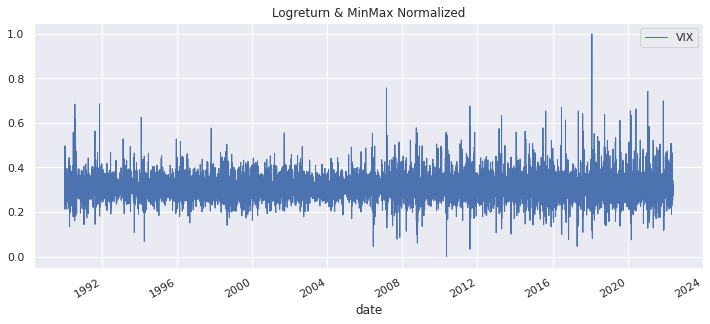

In [10]:
# Log Return
data = np.log(data/data.shift(1)).dropna()

# Normalize time series
# data = (data-data.mean())/data.std()            # Mean Normalization
data = (data-data.min())/(data.max()-data.min())  # Min Max Normalization
data = data.dropna()                              # remove nan value

# Plot series
data.plot(title='Logreturn & MinMax Normalized')

#### <font color="blue">**Topological Data Analysis**

<AxesSubplot:title={'center':'Time Series'}, xlabel='date'>

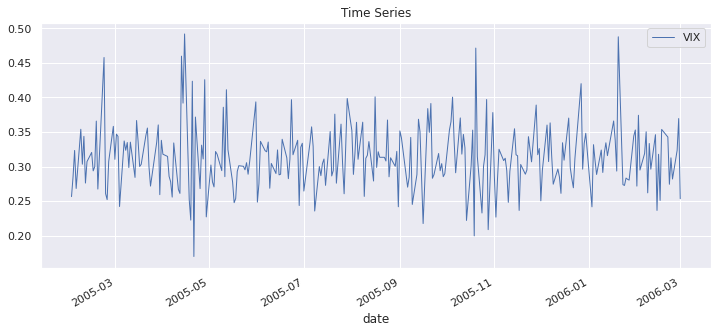

In [11]:
# Set Hyperparameter

# Define Time Frame
#series = data['2008-02-01':'2009-03-01']        # Containing a market shift
#series = data['2017-01-01':'2018-01-01']       # Containing no market shift
series = data['2005-02-01':'2006-03-01']        # Containing no market shift

# Hyperparameter for Takens Time Delay Embedding
embedding_dimension = 50                        # Upper bound for optimal embedding dimension d determined by false nearest neighbours
embedding_time_delay = 3                        # Upper bound for optimal time delay Tau determined by mutual information or ACF
parameters_type = "search"                      # Get optimal value for embedding_dimension & embedding_time_delay. Otherwise: "fixed"
stride = 1                                      # Increase stride to reduce amount of data
n_jobs=2                                        # Maximum number of jobs to use for the computation

# Hyperparameter for Persistence Diagrams
filtration = VietorisRipsPersistence            # Choose other filtration like "EuclideanCechPersistence" or "WeightedRipsPersistence"
homology_dimensions = [0, 1, 2, 3, 4]           # Persistence Diagrams with 0-connected components, 1-loops, 2-voids, and higher orders
reduced_homology=True                           # Allow more efficient computation
metric='euclidean'                              # Choose between 'euclidean' or 'manhattan' or 'cosine'

# Plot Time Series for the chosen window
series.plot(title='Time Series')

Optimal time delay (tau) based on mutual information: 1
Optimal embedding dimension based on false nearest neighbors: 5
Shape of embedded time series: (268, 5)


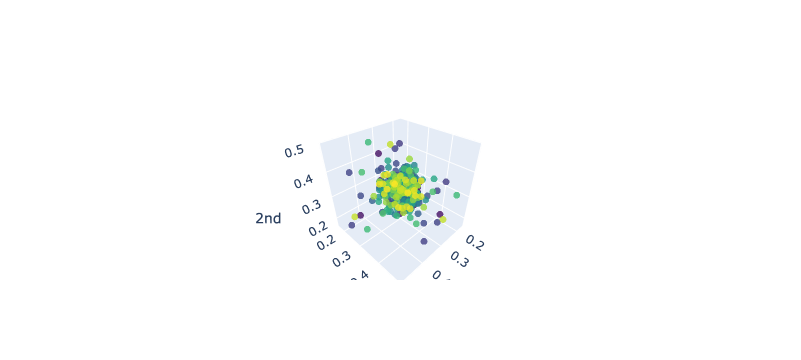

In [15]:
# Create Takens Embedding for Time Series
embedder = SingleTakensEmbedding(
    parameters_type=parameters_type,
    n_jobs=n_jobs,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

embedded = embedder.fit_transform(series.price)
print('Optimal time delay (tau) based on mutual information:',
      embedder.time_delay_)
print('Optimal embedding dimension based on false nearest neighbors:',
      embedder.dimension_)
print(f"Shape of embedded time series: {embedded.shape}")

plot_point_cloud(embedded)

In [ ]:
# Create Persistence Diagrams from Takens Time Delay Embedding
embedded = embedded[None, :, :]
persistence = filtration(
    homology_dimensions=homology_dimensions, metric=metric, n_jobs=n_jobs, reduced_homology=reduced_homology)
diagram = persistence.fit_transform_plot(embedded)

In [ ]:
# Create Betti Curves among Persistent Diagrams
betti = BettiCurve(n_bins=100, n_jobs=None)
betticurve = betti.fit_transform_plot(diagram)

In [ ]:
# Persistence Landscape from Persistent Diagrams
landscape = PersistenceLandscape(n_layers=1, n_bins=100, n_jobs=2)
landscape.fit_transform_plot(diagram)

In [ ]:
# Persistence images of persistence diagrams
#image = PersistenceImage(sigma=0.1, n_bins=100, weight_function=None, n_jobs=None)
#output = image.fit_transform_plot(diagram)
#print("Persistence Image for Time Series")